## Merge Root Files

In [ ]:
import uproot
import os
import numpy as np

def merge_files(directory, starts_with, output_name):

    file_list = []

    for file in os.listdir(directory):
        if file.endswith('.root') and not file.startswith('merge'):
            if not starts_with == '' and file.startswith(starts_with):
                    file_list.append(os.path.join(directory, file))
            else:
                file_list.append(os.path.join(directory, file))
    
    merged_file = os.path.join(directory, output_name)
    
    counter = 0
    while True:
        if not os.path.exists(f"{merged_file}{counter}.root"):
            merged_file = f"{merged_file}{counter}.root"
            break
        counter = counter + 1

    with uproot.recreate(merged_file) as f_out:
        data_dict = {}  # Dictionary to store merged data temporarily
        
        for file in file_list:
            
            with uproot.open(file) as f_in:
                for key in f_in.keys():
                    obj = f_in[key]
                    
                    if isinstance(obj, uproot.TTree):
                        new_data = obj.arrays(library="np")
                        
                        # Extract base key name (ignore cycle numbers)
                        base_key = key.split(';')[0]

                        # If base_key is already in data_dict, concatenate data
                        if base_key in data_dict:
                            existing_data = data_dict[base_key]
                            combined_data = {k: np.concatenate([existing_data[k], new_data[k]]) for k in new_data.keys() if k in existing_data}
                            # Update with the combined data
                            data_dict[base_key] = {**existing_data, **combined_data}
                        else:
                            # If base_key is not in data_dict, add new data
                            data_dict[base_key] = new_data

        for key, data in data_dict.items():
            f_out[key] = data


    print("Merged files into", merged_file)

In [ ]:
directory = 'build/root'
starts_with = 'root'
output_name = 'merged'

merge_files(directory, starts_with, output_name)

## Draw Graph from Merge.root

In [ ]:
import uproot
import matplotlib.pyplot as plt
import os

def scatterplot_from_root(directory, input_file, tree_name, x_branch, y_branch, title, x_label, y_label, output_image):

    input_file_path = os.path.join(directory, input_file)
    
    with uproot.open(input_file_path) as file:
        tree = file[tree_name]
        
        x_values = tree[x_branch].array()
        y_values = tree[y_branch].array()

    plt.figure(figsize=(8, 6))
    plt.scatter(x_values, y_values, color='blue', s=10, edgecolor='black')
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.savefig(output_image + '.jpg', format='jpg', dpi = 300)
    plt.close()
    
    print(f' ===== Scatter plot saved as {output_image}.jpg =====')

In [ ]:
directory = 'build/root'
file_name = 'root0' + '.root'

tree_name = "Photons"
x_branch = "X_axis"
y_branch = "Y_axis"

title = "title"
x_label = "x axis"
y_label = "y axis"

output_image = "xy_plot3"

scatterplot_from_root(directory, file_name, tree_name, x_branch, y_branch, title, x_label, y_label, output_image)

## Extraer .root -> Archivo CSV

In [ ]:
import uproot
import os
import csv

def copy_data_csv(directory, root_name_starts, tree_name, x_branch, y_branch, z_branch, csv_save_as):
    csv_file = os.path.join(directory, csv_save_as)
    
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['File', tree_name, x_branch, y_branch, z_branch])
        
        count = 0
        for file_name in sorted(os.listdir(directory)):

            if file_name.endswith('.root') and file_name.startswith(root_name_starts):
                file_path = os.path.join(directory, file_name)

                try:
                    # Open the ROOT file using uproot
                    with uproot.open(file_path) as root_file:
                        tree = root_file[tree_name]
                        if tree is None and count == 0:
                            print(f"Tree '{tree_name}' not found in {file_path}")
                            count += 1
                            continue

                        # Extract branches as arrays
                        x_values = tree[x_branch].array() if x_branch in tree else None
                        y_values = tree[y_branch].array() if y_branch in tree else None
                        z_values = tree[z_branch].array() if z_branch in tree else None

                        # Write data to CSV
                        for i in range(len(x_values)):
                            row = [file_name, tree_name, x_values[i]]
                            if y_values is not None:
                                row.append(y_values[i])
                            if z_values is not None:
                                row.append(z_values[i])
                            writer.writerow(row)

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                
    print('CSV file created as:', csv_file)

In [ ]:
directory = 'build/root/'
root_name_starts = "root4"

tree_name = "Photons"
x_branch  = "X_axis"
y_branch  = "Y_axis"
z_branch  = "Z_axis2"

csv_save_as = 'root4' + '.csv'

copy_data_csv(directory, root_name_starts, tree_name, x_branch, y_branch, z_branch, csv_save_as)

## Plot CSV (X axis vs. Y axis)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_xy(directory, csv_name, x_branch, y_branch, title, x_label, y_label):

    csv_file = os.path.join(directory, csv_name)
    df = pd.read_csv(csv_file)

    x = df[x_branch]
    y = df[y_branch]

    SIZE_DEFAULT = 14
    SIZE_LARGE = 20

    plt.rc("font", family = 'Century Expanded')  
    plt.rc("font", weight = "normal")  
    plt.rc("font",  size      = SIZE_DEFAULT)  
    plt.rc("axes",  titlesize = SIZE_LARGE + 2)  
    plt.rc("axes",  labelsize = SIZE_LARGE)  
    plt.rc("xtick", labelsize = SIZE_DEFAULT)  
    plt.rc("ytick", labelsize = SIZE_DEFAULT)  

    plt.figure(figsize = (10, 6))
    plt.tight_layout(rect = [0, 0.01, 1, 1])

    plt.plot(x, y, marker = 'o')
    plt.grid(True, alpha = 0.5)
    
    plt.xlabel(x_label, fontweight = "bold", labelpad = 21)
    plt.ylabel(y_label, fontweight = "bold", labelpad = 22)
    plt.title (title  , fontweight = "bold", pad = 25)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_alpha(0.3)
    ax.spines['right'].set_alpha(0.3)
    ax.spines['bottom'].set_alpha(0.7)
    ax.spines['left'].set_alpha(0.7)

    plt.savefig(title + '.png', dpi = 10)
    plt.show()

    print('Plot saved as', title + '.png')

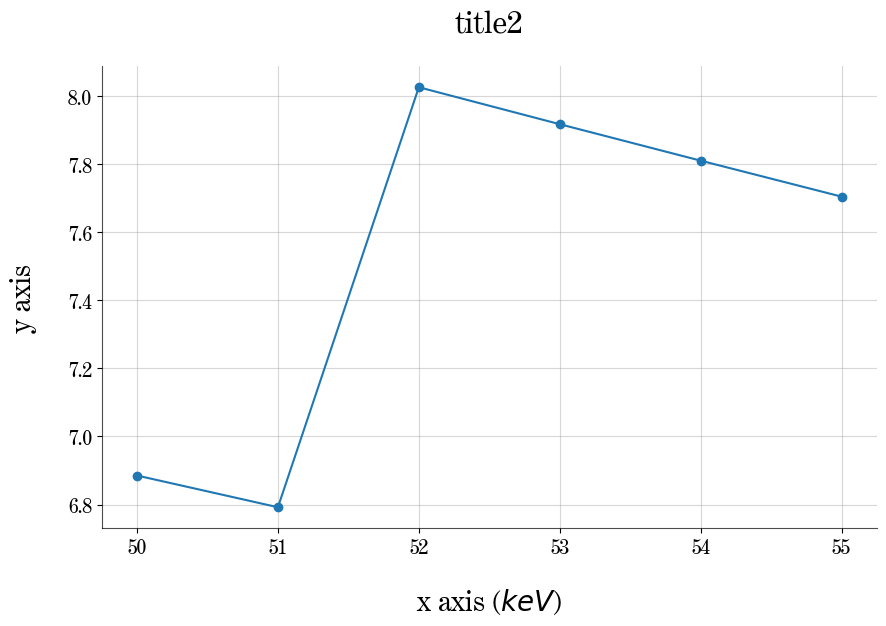

Plot saved as title2.png


In [105]:
directory = 'build/root/'
csv_name = 'Aluminio2.csv'

x_branch = "Energy"
y_branch = 'Optimal_Thickness'

title = "title2"
x_label = r"x axis ($keV$)"
y_label = r"y axis"

plot_xy(directory, csv_name, x_branch, y_branch, title, x_label, y_label)

## Plot CSV Histogram

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def histogram(directory, csv_name, data, set_bins, positive, title, x_label, y_label):

    csv_file = os.path.join(directory, csv_name)
    df = pd.read_csv(csv_file)

    points = df[data]
    if positive == True:
        points = df[df[data] > 0]

    plt.figure(figsize=(10, 7))
    #plt.tight_layout(rect=[0, 1, 1, 1])

    SIZE_DEFAULT = 14
    SIZE_LARGE = 20

    plt.rc("font", family = 'Merriweather')  
    plt.rc("font", weight = "normal")  
    plt.rc("font",  size      = SIZE_DEFAULT)  
    plt.rc("axes",  titlesize = SIZE_LARGE + 2)  
    plt.rc("axes",  labelsize = SIZE_LARGE)  
    plt.rc("xtick", labelsize = SIZE_DEFAULT)  
    plt.rc("ytick", labelsize = SIZE_DEFAULT)  

    plt.hist(points, bins = set_bins, alpha = 1)

    plt.title(title, pad = 15)
    plt.xlabel(x_label, labelpad = 15)
    plt.ylabel(y_label, labelpad = 15)
    plt.grid(True)

    plt.savefig(title + '.png', dpi = 300)
    plt.show()

    print('Plot saved as', title + '.png')

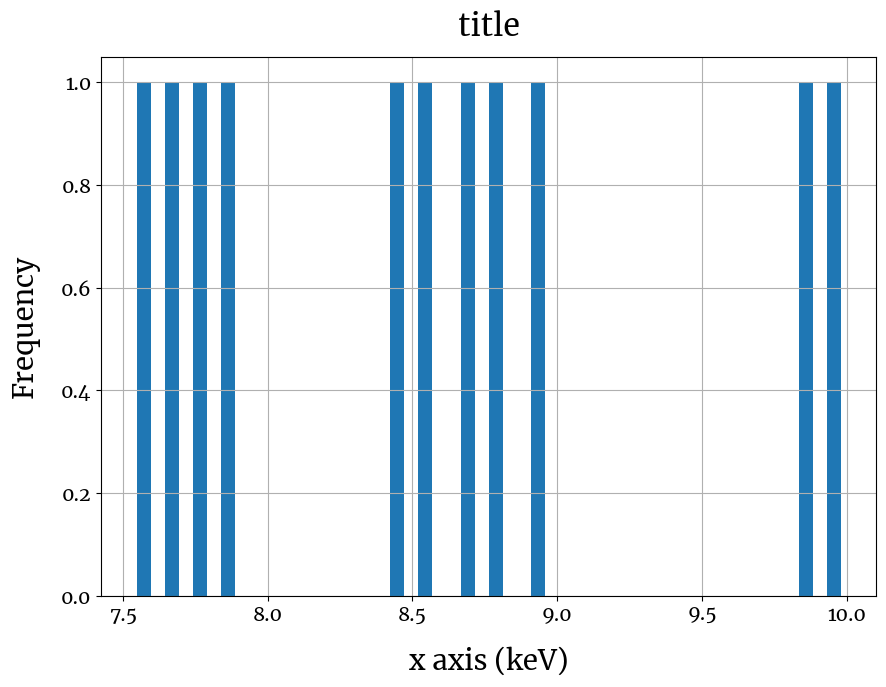

Plot saved as title.png


In [103]:
directory = 'build/root/'
csv_name = 'Aluminio.csv'

data = "Optimal_Thickness"
set_bins = 50
positive = False

title = 'title'
x_label = 'x axis (keV)'
y_label = 'Frequency'

histogram(directory, csv_name, data, set_bins, positive, title, x_label, y_label)

## Heatmap

In [ ]:
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

def heatmap(directory, csv_name, x_branch, y_branch, title, x_label, y_label, width, height):

    csv_file = os.path.join(directory, csv_name)
    print(csv_file)
    df = pd.read_csv(csv_file)

    x_data = df[x_branch]
    y_data = df[y_branch]

    fig = go.Figure(go.Histogram2d(
                    x = x_data, 
                    y = y_data,
                    autobinx = False,
                    xbins = dict(start = -150, end = 150, size = 3),
                    autobiny = False,
                    ybins = dict(start = -150, end = 150, size = 3),
                    colorscale = [[0, 'rgb(12,51,131)'], [0.25, 'rgb(10,136,186)'], [0.5, 'rgb(242,211,56)'], [0.75, 'rgb(242,143,56)'], [1, 'rgb(217,30,30)']]
                    ))
    
    font_family = 'Merriweather'
    font_small  = 16
    font_medium = 20
    font_large  = 28
    
    fig.update_layout(
                    title = dict(text = title, font = dict(family = font_family, size = font_large, color = "Black"), x = 0.5, yanchor = 'middle', xanchor = 'center'),
                    xaxis_title = dict(text = x_label, font = dict(family = font_family, size = font_medium, color = "Black")),
                    yaxis_title = dict(text = y_label, font = dict(family = font_family, size = font_medium, color = "Black")),
                    xaxis = dict(tickfont = dict(family = font_family, size = font_small, color = "Black"), title_standoff = 25),
                    yaxis = dict(tickfont = dict(family = font_family, size = font_small, color = "Black")),
                    width  = width,
                    height = height,
                    margin = dict(l = 105, r = 90, t = 90, b = 90),
                    yaxis_title_standoff = 10,
                    )
    
    pio.write_image(fig, "test.jpg", width = width, height = height, scale = 5)
    fig.show()

In [ ]:
directory = 'build/root/'
csv_name = 'test0.csv'

x_branch = "X_axis"
y_branch = 'Y_axis'

title = "Heatmap"
x_label = r"$ \large{ \text{X Axis ejemplo} \ (m^2)} $"
y_label = r"$ \large{ \text{Y Axis ejemplo} \ (cm^2)} $"

width  = 800
height = 800

heatmap(directory, csv_name, x_branch, y_branch, title, x_label, y_label, width, height)

## Heatmap 2x2

In [99]:
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

def heatmap(n, directory, csv_1, csv_2, csv_3, csv_4, x_branch, y_branch, title, x_label, y_label, width, height):

    df_1 = pd.read_csv(os.path.join(directory, csv_1))
    df_2 = pd.read_csv(os.path.join(directory, csv_2))

    x_data = [df_1[x_branch], df_2[x_branch]]
    y_data = [df_1[y_branch], df_2[y_branch]]

    if n > 2:
        df_3 = pd.read_csv(os.path.join(directory, csv_3))
        x_data.append(df_3[x_branch])
        y_data.append(df_3[y_branch])
        
        if n > 3:
            df_4 = pd.read_csv(os.path.join(directory, csv_4))
            x_data.append(df_4[x_branch])
            y_data.append(df_4[y_branch])

    fig = make_subplots(rows = 2, cols = 2, horizontal_spacing = 0.13, vertical_spacing = 0.13,
                        subplot_titles = ['Title for Subplot 1', 'Title for Subplot 2', 'Title for Subplot 3', 'Title for Subplot 4'])

    for i in range(2):
        for j in range(2):
            k = i * 2 + j 
            if k < n:  # Check to avoid out-of-bound errors
                fig.add_trace(go.Histogram2d(x = x_data[k], y = y_data[k], xbins = dict(size = 5), ybins = dict(size = 5)), row = i+1, col = j+1,)

    font_family = 'Merriweather'
    font_small  = 12
    font_medium = 16
    font_large  = 20
    
    fig.update_layout(title = dict(text = title, font = dict(family = font_family, size = font_large, color = "Black"), x = 0.5, yanchor = 'middle', xanchor = 'center'),
                      width = width, height = height, margin = dict(l = 105, r = 105, t = 100, b = 100), yaxis_title_standoff = 15)
    
    for i in range(2):
        for j in range(2):
            fig.update_xaxes(tickfont = dict(family = font_family, size = font_small, color = "Black"), row = i+1, col = j+1, title_standoff = 30) # range = [-200, 200]
            fig.update_yaxes(tickfont = dict(family = font_family, size = font_small, color = "Black"), row = i+1, col = j+1, title_standoff = 15)
    
    fig.update_xaxes(title_text = "xaxis 1 title", title_font = dict(family = font_family, size = font_medium, color = "Black"), row = 2, col = 2)
    fig.update_xaxes(title_text = "xaxis 1 title", title_font = dict(family = font_family, size = font_medium, color = "Black"), range=[-200, 200], row = 2, col = 1)
    fig.update_yaxes(title_text = "yaxis 1 title", title_font = dict(family = font_family, size = font_medium, color = "Black"), row = 1, col = 1)
    fig.update_yaxes(title_text = "yaxis 2 title", title_font = dict(family = font_family, size = font_medium, color = "Black"), range=[-200, 200], row = 2, col = 1)
    
    pio.write_image(fig, "test.jpg", width = width, height = height, scale = 5)
    fig.show()

In [100]:
n = 4

directory = 'BUILD/ROOT/'

csv_1 = 'root0.csv'
csv_2 = 'root1.csv'
csv_3 = 'root2.csv'
csv_4 = 'root4.csv'

x_branch = "X_axis"
y_branch = 'Y_axis'

title = "Heatmap"
x_label = r"$ \large{ \text{X Axis ejemplo} \ (m^2)} $"
y_label = r"$ \large{ \text{Y Axis ejemplo} \ (cm^2)} $"

width  = 800
height = 800

heatmap(n, directory, csv_1, csv_2, csv_3, csv_4, x_branch, y_branch, title, x_label, y_label, width, height)